# Demeanor of suspects stopped by the NYPD in 2019

In [3]:
# Import packages for this analysis 

import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import squarify
from wordcloud import WordCloud
from spellchecker import SpellChecker
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
%matplotlib inline

custom_style = {'axes.titlesize':'15',
                'axes.titlecolor':'white',
                'xtick.color': 'black',
                'ytick.color': 'black'}
sns.set(style= 'darkgrid', rc=custom_style)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/livernteo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
sqf = pd.read_csv('data/2019_sqf_race_demenour.csv')
sqf.head()

,stop_id,suspect_race_description,demeanor_of_person_stopped
0,2019-1,BLACK,UNDERSTANDING
1,2019-2,BLACK,NORMAL
2,2019-3,WHITE,CALM
3,2019-4,BLACK,CONFUSED
4,2019-6,BLACK,COORPERATIVE


In [39]:
# checking for empty cells 
sqf.describe()

,stop_id,suspect_race_description,demeanor_of_person_stopped
count,13272,13184,13218
unique,12313,6,1887
top,2.02E+12,BLACK,CALM
freq,960,7854,4037


In [40]:
# removing the whole row if either race or demeanor is empty (small % anyway)
sqf.dropna(how='any',inplace=True)

In [37]:
# splitting the demeanor to string
# sqf['split'] = sqf['demeanor_of_person_stopped'].apply(lambda x : x.split())
# sqf['split']

0                [UNDERSTANDING]
1                       [NORMAL]
2                         [CALM]
3                     [CONFUSED]
4                 [COORPERATIVE]
                  ...           
13267                   [NORMAL]
13268                     [CALM]
13269                   [NORMAL]
13270              [INTOXICATED]
13271    [NERVOUS, AND, EVASIVE]
Name: split, Length: 13131, dtype: object

In [41]:
# order alphabetically
sqf.sort_values(by='demeanor_of_person_stopped',inplace=True)

In [42]:
# correcting 2 obvious spelling mistakes (had unique symbol)
sqf['demeanor_of_person_stopped'].loc[2790] = 'UNCOOPERATIVE'
sqf['demeanor_of_person_stopped'].loc[5875] = 'UPSET, COOPERATIVE'

In [43]:
# find and replace instances of NON with NON-
sqf['demeanor_of_person_stopped'] = sqf['demeanor_of_person_stopped'].apply(
    lambda x: x.replace("NON ", "NON-"))

In [44]:
# apply lambda function to 'demeanor_of_person_stopped' column which turns
# sentenes into lists
sqf['split'] = sqf['demeanor_of_person_stopped'].apply(lambda x : re.findall('[a-zA-Z\-]+',x))
sqf

,stop_id,suspect_race_description,demeanor_of_person_stopped,split
6864,2019-7520,BLACK,"""AFRAID""",[AFRAID]
11572,2019-12676,WHITE HISPANIC,"""CALM""",[CALM]
1882,2019-2014,WHITE HISPANIC,- ANGRY AND SLIGHTLY UNCOOPERATIVE -,"[-, ANGRY, AND, SLIGHTLY, UNCOOPERATIVE, -]"
2790,2019-3035,BLACK,UNCOOPERATIVE,[UNCOOPERATIVE]
5875,2019-6423,BLACK,"UPSET, COOPERATIVE","[UPSET, COOPERATIVE]"
...,...,...,...,...
7575,2019-8318,BLACK,YELLING,[YELLING]
8829,2019-9738,BLACK,YELLING,[YELLING]
1161,2019-1209,BLACK,YELLING AND LAUGHING,"[YELLING, AND, LAUGHING]"
1160,2019-1208,BLACK,YELLING AND LAUGHING,"[YELLING, AND, LAUGHING]"


In [45]:
# create spellchecker object
spell = SpellChecker()

In [46]:
# create a function that does the spell check for every word in a list 
def spellcheck(split_array): 
    return_array = []
    for word in split_array:
        return_array.append(spell.correction(word).upper())
    return return_array

In [47]:
# spell check the split column and return 'spellcheck_demeanor' with correct spellings 
# (this might take a while...)
sqf['spellcheck_demeanor'] = sqf['split'].apply(lambda x: spellcheck(x))
sqf

,stop_id,suspect_race_description,demeanor_of_person_stopped,split,spellcheck_demeanor
6864,2019-7520,BLACK,"""AFRAID""",[AFRAID],[AFRAID]
11572,2019-12676,WHITE HISPANIC,"""CALM""",[CALM],[CALM]
1882,2019-2014,WHITE HISPANIC,- ANGRY AND SLIGHTLY UNCOOPERATIVE -,"[-, ANGRY, AND, SLIGHTLY, UNCOOPERATIVE, -]","[-, ANGRY, AND, SLIGHTLY, UNCOOPERATIVE, -]"
2790,2019-3035,BLACK,UNCOOPERATIVE,[UNCOOPERATIVE],[UNCOOPERATIVE]
5875,2019-6423,BLACK,"UPSET, COOPERATIVE","[UPSET, COOPERATIVE]","[UPSET, COOPERATIVE]"
...,...,...,...,...,...
7575,2019-8318,BLACK,YELLING,[YELLING],[YELLING]
8829,2019-9738,BLACK,YELLING,[YELLING],[YELLING]
1161,2019-1209,BLACK,YELLING AND LAUGHING,"[YELLING, AND, LAUGHING]","[YELLING, AND, LAUGHING]"
1160,2019-1208,BLACK,YELLING AND LAUGHING,"[YELLING, AND, LAUGHING]","[YELLING, AND, LAUGHING]"


# Create table of different words used, and the number of times used, grouped by race

In [48]:
# creating a list of stop words
stop_words = stopwords.words('english')
# (changing to upper to accomodate original dataset)
stop_words = [x.upper() for x in stop_words]

In [49]:
# function to count number of words 
def word_count(total_words_array):
    counts = dict()
    
    for word in total_words_array:
        if word in counts: 
            counts[word] += 1
        else: 
            counts[word] = 1
    return counts 

In [50]:
# function that will accept a series and produce a dataframe of word counts for the series
def race_word_count(spellcheck_demeanor_race):
    ''' accept a series and produce a dataframe of word counts for the series '''
    words_array = []
    
    # adds non-stop words from the series to the words_array list
    for row in spellcheck_demeanor_race: 
        for r in row:
            if r not in stop_words: 
                words_array.append(r)
    
    # uses the function word_count to count individual words from wrods_array
    # stores output in df_word_count
    df_word_count = pd.DataFrame.from_dict(word_count(words_array),
                                       orient='Index',columns=['Count'])

    return df_word_count.sort_values('Count',ascending=False)
    

In [51]:
# word count for suspects by race 
black_word_count = race_word_count(
    sqf[sqf['suspect_race_description'] == 'BLACK']['spellcheck_demeanor'])
white_word_count = race_word_count(
    sqf[sqf['suspect_race_description'] == 'WHITE']['spellcheck_demeanor'])
black_hispanic_word_count = race_word_count(
    sqf[sqf['suspect_race_description'] == 'BLACK HISPANIC']['spellcheck_demeanor'])
white_hispanic_word_count = race_word_count(
    sqf[sqf['suspect_race_description'] == 'WHITE HISPANIC']['spellcheck_demeanor'])
asian_pacific_word_count = race_word_count(
    sqf[sqf['suspect_race_description'] == 'ASIAN / PACIFIC ISLANDER']['spellcheck_demeanor'])
native_alaskan_word_count = race_word_count(
    sqf[sqf['suspect_race_description'] == 'AMERICAN INDIAN/ALASKAN N']['spellcheck_demeanor'])

In [52]:
# renaming the count columns; individual race datasetes 
white_word_count.rename(columns={'Count':'white_count'},inplace=True)
black_word_count.rename(columns={'Count':'black_count'},inplace=True)
white_hispanic_word_count.rename(columns={'Count':'white_hispanic_count'},inplace=True)
black_hispanic_word_count.rename(columns={'Count':'black_hispanic_count'},inplace=True)
asian_pacific_word_count.rename(columns={'Count':'asian_pacific_count'},inplace=True)
native_alaskan_word_count.rename(columns={'Count':'native_alaskan_count'},inplace=True)


In [53]:
# complete dataframe of all records
df_total_count = pd.concat([white_word_count, black_word_count, white_hispanic_word_count,
                           black_hispanic_word_count, asian_pacific_word_count, 
                           native_alaskan_word_count], axis=1)
# save in .csv (ease of access)
df_total_count.to_csv('results/2019_word_cloud.csv')

In [54]:
# preview the dataframe
df_total_count.head(10)

,white_count,black_count,white_hispanic_count,black_hispanic_count,asian_pacific_count,native_alaskan_count
CALM,442.0,2723.0,924.0,372.0,121.0,1.0
NERVOUS,210.0,1109.0,494.0,210.0,49.0,1.0
NORMAL,103.0,488.0,205.0,92.0,17.0,NaN
COOPERATIVE,68.0,362.0,170.0,70.0,15.0,2.0
UPSET,57.0,596.0,150.0,82.0,10.0,NaN
COMPLIANT,53.0,272.0,129.0,48.0,12.0,NaN
AGITATED,31.0,322.0,99.0,34.0,10.0,NaN
ANGRY,27.0,335.0,77.0,32.0,1.0,NaN
CONFUSED,23.0,110.0,48.0,15.0,8.0,NaN
ANNOYED,15.0,212.0,49.0,22.0,2.0,NaN


# Produing a treemap of stops, grouped by suspect race

In [56]:
df_tree = pd.DataFrame(sqf.groupby(['suspect_race_description']).count()['stop_id'])
df_tree

,stop_id
suspect_race_description,
AMERICAN INDIAN/ALASKAN N,7
ASIAN / PACIFIC ISLANDER,283
BLACK,7830
BLACK HISPANIC,1127
WHITE,1178
WHITE HISPANIC,2706


In [57]:
df_tree.reset_index(inplace=True)
df_tree.columns = ['suspect_race_description','stop_count']

<AxesSubplot:>

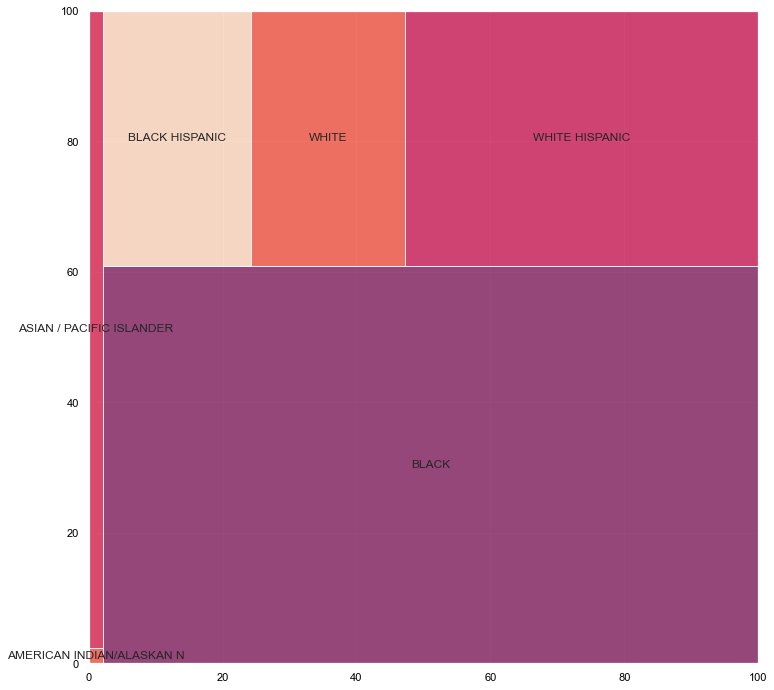

In [22]:
fig, ax = plt.subplots(1, figsize = (12,12))
squarify.plot(sizes=df_tree['stop_count'],
              label=df_tree['suspect_race_description'],
             alpha=0.8)

# Producing a word cloud of demeanors used for suspects, grouped by race

In [58]:
def string_words(spellcheck_demeanor_race):
    '''function accepts a series and returns a string of words'''
    string_words = ""

    for row in series: 
        for r in row:
            if r not in stop_words: 
                  string_words = string_words + " " + r
    
    return string_words

In [59]:
# function to turn text in word cloud black
def black_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 1%, 30%)"

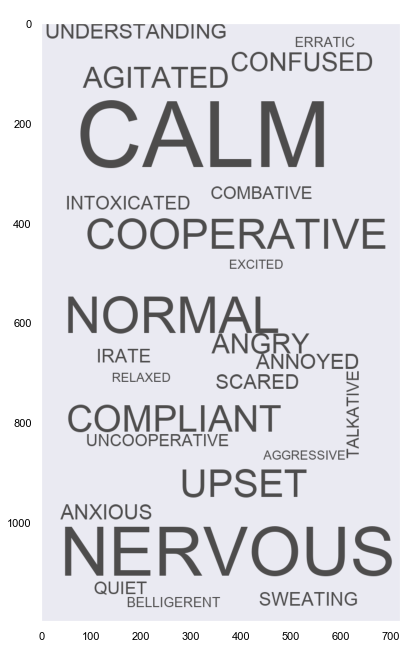

In [61]:
# checking the top 50 words for each race and removing the ones that aren't an emotion
white_word_count.head(50)

# remove the words "extremely", "apparently", "highly", "profusely" - it's not a demeanor
white_string_words = string_words(sqf[sqf['suspect_race_description'] == 'WHITE']['spellcheck_demeanor'])
white_string_words = white_string_words.replace("EXTREMELY", " ")
white_string_words = white_string_words.replace("APPARENTLY", " ")
white_string_words = white_string_words.replace("HIGHLY", " ")
white_string_words = white_string_words.replace("PROFUSELY", " ")

# create the word cloud
wordcloud = WordCloud(width = 720, height = 1200, font_path='Arial',
                      background_color=None, max_words = 25,
                      mode='RGBA',
                      prefer_horizontal=0.9,
                      collocations=False, color_func= black_color_func).generate(white_string_words)
wordcloud.to_file("results/white_stops_cloud.png")
plt.figure(figsize = (15, 11), facecolor = None) 
plt.imshow(wordcloud) 
plt.grid(False)
plt.title('White Stops Word Cloud')
plt.show()

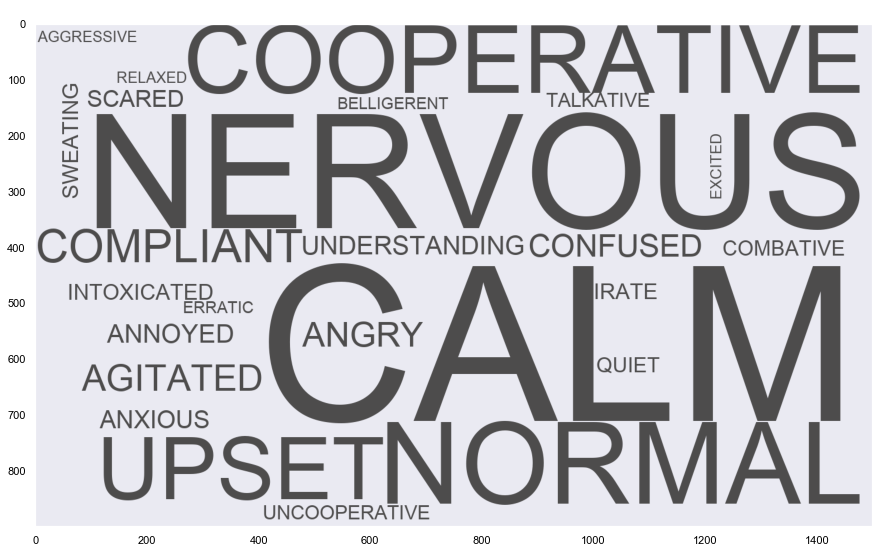

In [62]:
# checking the top 50 words for each race and removing the ones that aren't an emotion
black_word_count.head(50)

# remove the words "apparently", "highly", "stop", "person" - it is not a demeanor
black_string_words = string_words(sqf[sqf['suspect_race_description'] == 'WHITE']['spellcheck_demeanor'])
black_string_words = black_string_words.replace("STOP", " ")
black_string_words = black_string_words.replace("APPARENTLY", " ")
black_string_words = black_string_words.replace("HIGHLY", " ")
black_string_words = black_string_words.replace("PERSON", " ")

# create the wordcloud
wordcloud = WordCloud(width =1500, height = 900, font_path='Arial',
                      background_color=None, max_words = 25,
                      mode='RGBA',
                      prefer_horizontal=0.85,
                      collocations=False, color_func= black_color_func).generate(black_string_words)
wordcloud.to_file("results/black_stops_cloud.png")
plt.figure(figsize = (15, 11), facecolor = None) 
plt.imshow(wordcloud) 
plt.grid(False)
plt.title('White Word Cloud')
plt.show()